# Normality in Hyperbolic Spaces + Curvature

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Utilities for hyperbolic space

We need distance functions, etc

In [16]:
def hyper_distance(p, q, K):
    return 1/np.sqrt(-K) * np.arccosh(K * hyper_dp(p,q))

def hyper_dp(p, q):
    return -p[0]*q[0] + np.dot(p[1:], q[1:])

def hyper_norm(p):
    return np.sqrt(hyper_dp(p, p))

def random_point(d, K):
    q = np.random.rand(d+1)
    q[0] = np.sqrt(1.0/-K + np.linalg.norm(q[1:])**2)
    # in case we have slight underflow:
    if hyper_dp(q,q) > -1.0:
        q /= -hyper_dp(q,q)
    return q

def exp_map(x, v):
    return np.cosh(hyper_norm(v))*x + np.sinh(hyper_norm(v))*v/hyper_norm(v)

def log_map(x, y):
    alpha = -hyper_dp(x, y)
    return np.arccosh(alpha)/np.sqrt(alpha**2-1)*(y-alpha*x)

def parallel_transport(p,q,v):
    alpha = -hyper_dp(p,q)
    return v + hyper_dp(q, v)/(1-hyper_dp(p,q))*(p+q)


In [17]:
# Sanity checks:
d = 5
K = -1.0
north_star = np.zeros(d+1)
north_star[0] = np.sqrt(-K)
q = random_point(d, K)
print(f"q = {q}")
print(f"dp = {hyper_dp(q,q)}")

print(f"These should be -1.0: {hyper_dp(north_star, north_star)}, {hyper_dp(q,q)}")
print(f"Distance q, ns = {hyper_distance(north_star, q, K)}")
print(f"Distance q, q  = {hyper_distance(q,q, K)}")

v = np.array([0,0,0,0,0,1])
ep = exp_map(north_star, np.array([0,0,0,0,0,1]))
#print(hyper_distance(north_star, ep, K))
#print(log_map(north_star, ep))


q = [1.7566162  0.54266721 0.6936862  0.43508953 0.8858114  0.57969604]
dp = -1.0000000000000004
These should be -1.0: -1.0, -1.0000000000000004
Distance q, ns = 1.163404415456607
Distance q, q  = 2.980232238769531e-08


In [18]:
# let's get 3 points and verify the law of cosines
pa = north_star
pb = random_point(d, K)
pc = random_point(d, K)

vb = log_map(pa, pb)
vc = log_map(pa, pc)

# alpha is actually cos(alpha)
alpha = np.dot(vb, vc) / (np.linalg.norm(vb) * np.linalg.norm(vc))

a = hyper_distance(pb, pc, K)
b = hyper_distance(pa, pc, K)
c = hyper_distance(pa, pb, K)

print(f"law of cosines lhs {np.cosh(a)}")
print(f"law of cosines rhs {np.cosh(b)*np.cosh(c)-np.sinh(b)*np.sinh(c)*alpha}")



law of cosines lhs 1.3153833257243186
law of cosines rhs 1.3153833257243186


In [19]:
def single_run(n_samples, verbose=False):
    theta1, theta2, theta3 = np.random.rand(3) * 5.0
    if verbose: print(f"thetas are {theta1, theta2, theta3}")
    v_mu = np.zeros(d)
    v_cov1 = np.eye(d)*theta1
    v_cov2 = np.eye(d)*theta2
    v_cov3 = np.eye(d)*theta3

    p1s = np.zeros((n_samples, d+1))
    p2s = np.zeros((n_samples, d+1))
    p3s = np.zeros((n_samples, d+1))

    v1s = np.random.multivariate_normal(v_mu, v_cov1, n_samples)
    v2s = np.random.multivariate_normal(v_mu, v_cov2, n_samples)
    v3s = np.random.multivariate_normal(v_mu, v_cov3, n_samples)

    ca, cb, cc, cab, cac, cbc = 0, 0, 0, 0, 0, 0
    ta, tab, tac, tbc = 0, 0, 0, 0

    for i in range(n_samples):
        tmp = np.zeros(d+1)
        tmp[1:] = v1s[i]
        p1s[i] = exp_map(north_star, tmp)
        tmp[1:] = v2s[i]
        p2s[i] = exp_map(north_star, tmp)
        tmp[1:] = v3s[i]
        p3s[i] = exp_map(north_star, tmp)

        #alpha += np.dot(v1s[i], v2s[i]) / (np.linalg.norm(v1s[i]) * np.linalg.norm(v2s[i]))
        ab = np.cosh(hyper_distance(p1s[i], p2s[i], K))
        ac = np.cosh(hyper_distance(p1s[i], p3s[i], K))
        bc = np.cosh(hyper_distance(p2s[i], p3s[i], K))
        
        a = np.cosh(hyper_distance(north_star, p1s[i], K))
        b = np.cosh(hyper_distance(north_star, p2s[i], K))
        c = np.cosh(hyper_distance(north_star, p3s[i], K))

        # these are for the non-cosh distances
        tab += hyper_distance(p1s[i], p2s[i], K)
        tac += hyper_distance(p1s[i], p3s[i], K)
        tbc += hyper_distance(p2s[i], p3s[i], K)
        ta += hyper_distance(north_star, p1s[i], K)

        ca += a
        cb += b
        cc += c
        cbc += b*c
        cab += a*b
        cac += a*c
    ca /= n_samples
    cb /= n_samples
    cc /= n_samples
    cbc /= n_samples
    cac /= n_samples
    cab /= n_samples
    tab /= n_samples
    tbc /= n_samples
    tac /= n_samples
    ta /= n_samples 
    # Compute the triplet-based baseline here
    avg_sq_dist_a = (tab**2 + tac**2 - tbc**2)/2.0
    print(f"got avg {avg_sq_dist_a} true was {ta**2}")

    # compute the actual guesses
    ahat = np.sqrt(cab*cac/cbc)
    bhat = np.sqrt(cab*cbc/cac)
    chat = np.sqrt(cac*cbc/cab)

    if verbose:
        print(f"tru cos distances a,b,c = {ca,cb,cc}")
        print(f"rec cos distances a,b,c = {ahat,bhat,chat}")

    # need to convert cosh(dist) to squared distance or to thetas
    # let's recover values of theta in a dumb search way

    # grid searching for theta from >0.0 to 5.0 (can expand if needed)
    best_err, best_theta_cand = 1.0e10, 0.0
    best_err_uws, best_theta_cand_uws = 1.0e10, 0.0

    n_search_samples = 10000
    for cand in range(1, 100):
        cand_theta = cand/20.0 # grid of size 20 over 0.0 to 5.0

        #print(f"looking at {cand_theta}")
        cand_cov = np.eye(d)*cand_theta
        # generate a bunch of samples:
        pcands = np.zeros((n_search_samples, d+1))
        vs = np.random.multivariate_normal(v_mu, cand_cov, n_search_samples)

        ca, ta = 0, 0

        for i in range(n_search_samples):
            tmp = np.zeros(d+1)
            tmp[1:] = vs[i]
            pcands[i] = exp_map(north_star, tmp)
            pa = np.cosh(hyper_distance(north_star, pcands[i], K))
            ca += pa
            ta += hyper_distance(north_star, pcands[i], K)
        ca /= n_search_samples
        ta /= n_search_samples
        #print(f"current error = {np.abs(ca - ahat)}")
        if np.abs(ca - ahat) < best_err:
            best_theta_cand = cand_theta
            best_err = np.abs(ca-ahat)
        if np.abs(ta**2 - avg_sq_dist_a) < best_err_uws:
            best_theta_cand_uws = cand_theta
            best_err_uws = np.abs(ta**2 - avg_sq_dist_a)
    
    rec_err = np.abs(theta1-best_theta_cand)
    rec_err_uws = np.abs(theta1 - best_theta_cand_uws)
    if verbose: print(f"recovered best a theta of {best_theta_cand} with error of {rec_err}")
    return rec_err, rec_err_uws


In [23]:
trials = 10 # TODO change to 10
mean_perf = np.zeros(trials)
mean_perf_uws = np.zeros(trials)

ns = [100, 500, 1_000, 5_000, 10_000, 50_000, 100_000, 500_000, 1_000_000]
ns = ns[:]

n_cands = np.zeros(5).astype(int)

perfs = np.zeros((len(ns), trials))
perfs_uws = np.zeros((len(ns), trials))

print(ns)
print(n_cands)

for i in range(len(ns)):
    print(f"samples = {ns[i]}")
    for j in range(trials):
        print(f"Doing run {j} of {trials}")
        rec_err, rec_err_uws = single_run(ns[i], verbose=False)
        print(f"Got errors of {rec_err} and uws {rec_err_uws}")
        perfs[i, j] = rec_err
        perfs_uws[i, j] = rec_err_uws



[100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]
[0 0 0 0 0]
samples = 100
Doing run 0 of 10
got avg 30.04429510885308 true was 19.126060766617297
Got errors of 0.2620096210840046 and uws 0.7379903789159954
Doing run 1 of 10
got avg 0.45414651289028285 true was 4.808322783834977
Got errors of 0.11468164594294195 and uws 0.8853183540570582
Doing run 2 of 10
got avg -5.733824690163168 true was 1.7614483494092066
Got errors of 0.17935009963096726 and uws 0.3206499003690328
Doing run 3 of 10
got avg 26.44671674512438 true was 18.043888327698586
Got errors of 0.026805782165258307 and uws 1.023194217834742
Doing run 4 of 10
got avg 18.913748882020087 true was 15.816171976799811
Got errors of 0.2812726748555501 and uws 0.7312726748555503
Doing run 5 of 10
got avg -1.1829017368545962 true was 0.7645829731449353
Got errors of 0.010960928657779562 and uws 0.11096092865777955
Doing run 6 of 10
got avg 17.659741684894204 true was 11.242677905324474
Got errors of 0.4501721489906605 and

In [32]:
# Save the computations
np.save('hyperbolic_perfs', perfs)
np.save('hyperbolic_perfs_uws', perfs_uws)

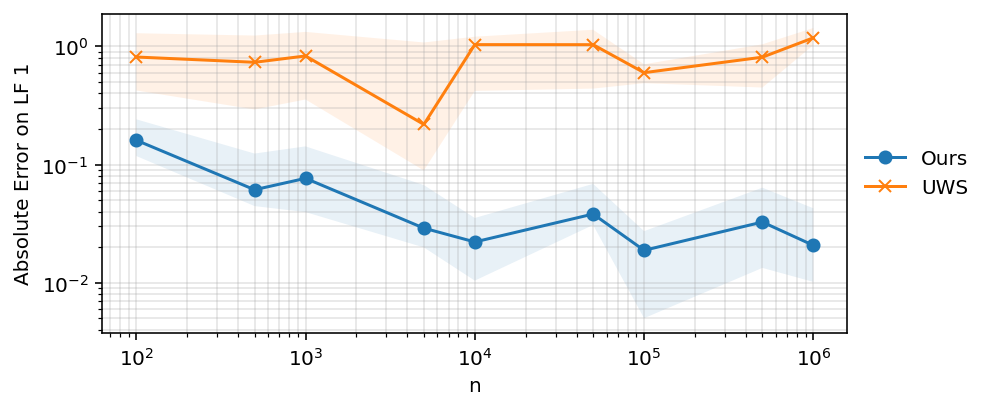

In [44]:
# Plotting
from turtle import position


plt.figure(figsize=(7, 3))

ns = [int(n) for n in ns]

q = 0.25
mean0 = np.median(perfs, axis=1)
max0 = np.quantile(perfs, 1.0 - q, axis=1)
min0 = np.quantile(perfs, q, axis=1)
plt.plot(ns, mean0, label=r'Ours', marker='o')
plt.fill_between(ns, min0, max0, alpha=0.1)

mean0 = np.median(perfs_uws, axis=1)
max0 = np.quantile(perfs_uws, 1.0 - q, axis=1)
min0 = np.quantile(perfs_uws, q, axis=1)
plt.plot(ns, mean0, label=r'UWS', marker='x')
plt.fill_between(ns, min0, max0, alpha=0.1)

plt.xscale('log')
plt.xlabel('n')
plt.yscale('log')
plt.ylabel('Absolute Error on LF 1')
plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, which="both", ls="-", alpha=0.3, color='0.65')
plt.tight_layout()
plt.savefig('est_hyperbolic.pdf')
plt.savefig('est_hyperbolic.png')
plt.show()


